In [ ]:
# Imports used in this notebook. This is Python 3 on Jupyter with matplotlib.
%matplotlib inline
import matplotlib.pyplot as plt
import random
from itertools   import permutations, combinations
from functools   import lru_cache as cache
from collections import Counter
from statistics  import mean, median
import pandas as pd
import time
import numpy
import random, operator, time, itertools, math
import matplotlib.colors as colors
import matplotlib.cm as cmx



In [ ]:
def exhaustive_tsp(cities):
    "Generate all possible tours of the cities and choose the shortest tour."
    return shortest_tour(alltours(cities))

def shortest_tour(tours): return min(tours, key=tour_length)

# TO DO: Data types: City, Cities, Tour; Functions: alltours, tour_length

In [ ]:
def alltours(cities):
    "Return a list of non-redundant tours (permutations of cities)."
    start, *others = cities
    return [[start] + Tour(perm) for perm in permutations(others)]
    
Tour = list  # A Tour is a list of cities

In [ ]:
def do(algorithm, cities):
    "Apply a TSP algorithm to cities, plot the result, and print info."
    t0 = time.process_time()
    tour = algorithm(cities)
    t1 = time.process_time()
    assert Counter(tour) == Counter(cities) # Every city appears exactly once in tour
    plot_tour(tour)
    plt.text(x=461,y=295,s="City A",fontsize=10)
    plt.text(x=471,y=19,s="City B",fontsize=10)
    plt.text(x=631,y=636,s="City C",fontsize=10)
    plt.text(x=734,y=292,s="City D",fontsize=10)
    plt.text(x=74,y=79,s="City E",fontsize=10)
    print("{}: {} cities ⇒ tour length {:.0f} (in {:.3f} sec)".format(
          name(algorithm), len(tour), tour_length(tour), t1 - t0))
    
def name(algorithm): return algorithm.__name__.replace('_tsp', '')

In [ ]:
def tour_length(tour):
    """The total of distances between each pair of consecutive cities in the tour.
    This includes the last-to-first, distance(tour[-1], tour[0])"""
    return sum(distance(tour[i - 1], tour[i]) 
               for i in range(len(tour)))

City = complex

def distance(A, B): return abs(A - B)

def Cities(n, seed=391, width=999, height=666):
    "Make a set of n cities, sampled uniformly from a (width x height) rectangle."
    random.seed((n, seed))
    return set(City(random.randint(1, width), random.randint(1, height))
                     for c in range(n))

In [ ]:
def plot_tour(tour, style='bo-'): 
    "Plot every city and link in the tour, and highlight start city."
    if len(tour) > 1000: plt.figure(figsize=(15, 10))
    start = tour[0:1]
    plot_segment(tour + start, style) 
    plot_segment(start, 'rD')
    
def plot_segment(segment, style='bo-'):
    "Plot every city and link in the segment."
    plt.plot([X(c) for c in segment], [Y(c) for c in segment], style, clip_on=False)
    plt.axis('scaled')
    plt.axis('on')
    
def X(city): "X coordinate."; return city.real
def Y(city): "Y coordinate."; return city.imag

In [ ]:
def join_endpoints(endpoints, A, B):
    "Join segments [...,A] + [B,...] into one segment. Maintain `endpoints`."
    Aseg, Bseg = endpoints[A], endpoints[B]
    if Aseg[-1] is not A: Aseg.reverse()
    if Bseg[0]  is not B: Bseg.reverse()
    Aseg += Bseg
    del endpoints[A], endpoints[B] 
    endpoints[Aseg[0]] = endpoints[Aseg[-1]] = Aseg
    return Aseg

In [ ]:
def improve_tour(tour):
    "Try to alter tour for the better by reversing segments."
    while True:
        improvements = {reverse_segment_if_improvement(tour, i, j)
                        for (i, j) in subsegments(len(tour))}
        if improvements == {None}:
            return tour

@cache()
def subsegments(N):
    "Return (i, j) pairs denoting tour[i:j] subsegments of a tour of length N."
    return [(i, i + length)
            for length in reversed(range(2, N))
            for i in reversed(range(N - length + 1))]

In [ ]:
def reverse_segment_if_improvement(tour, i, j):
    "If reversing tour[i:j] would make the tour shorter, then do it." 
    # Given tour [...A,B...C,D...], consider reversing B...C to get [...A,C...B,D...]
    A, B, C, D = tour[i-1], tour[i], tour[j-1], tour[j % len(tour)]
    # Are old links (AB + CD) longer than new ones (AC + BD)? If so, reverse segment.
    if distance(A, B) + distance(C, D) > distance(A, C) + distance(B, D):
        tour[i:j] = reversed(tour[i:j])
        return True

In [ ]:
pip install deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 KB 3.5 MB/s eta 0:00:00


In [ ]:
from deap import algorithms, base, creator, tools

In [ ]:
toolbox = base.Toolbox()

In [ ]:
def create_tour(individual):
    return [list(cities)[e] for e in individual]

In [ ]:
def alltours(cities):
    "Return a list of non-redundant tours (permutations of cities)."
    start, *others = cities
    return [[start] + Tour(perm) for perm in permutations(others)]
    
Tour = list  # A Tour is a list of cities

In [ ]:
def evaluation(individual):
    '''Evaluates an individual by converting it into 
    a list of cities and passing that list to total_distance'''
    return (total_distance(create_tour(individual)),)

In [ ]:
def total_distance(tour):
    "The total distance between each pair of consecutive cities in the tour."
    return sum(distance(tour[i], tour[i-1]) 
               for i in range(len(tour)))

In [ ]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [ ]:
toolbox.register("evaluate", evaluation)

In [ ]:
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)

In [ ]:
cities=Cities(5)

In [ ]:
toolbox.register("indices", numpy.random.permutation, len(cities))
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list, 
                 toolbox.individual)

In [ ]:
pop_stats = tools.Statistics(key=numpy.copy)
pop_stats.register('pop', numpy.copy) # -- copies the populations themselves
pop_stats.register('fitness', # -- computes and stores the fitnesses
                   lambda x : [evaluation(a) for a in x]) 

In [ ]:
fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
fit_stats.register('mean', numpy.mean)
fit_stats.register('min', numpy.min)

In [ ]:
df1=[]
df2=[]
df3=[]
df=[]
for i in range(10,52,2):
  cities=Cities(i)
  toolbox.register("indices", numpy.random.permutation, len(cities))
  toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
  toolbox.register("population", tools.initRepeat, list, toolbox.individual)
  toolbox.register("select", tools.selTournament, tournsize=3)
  toolbox.register("mate", tools.cxOrdered)
  toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)
  creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
  creator.create("Individual", list, fitness=creator.FitnessMin)
  t0 = time.process_time()
  result,log=algorithms.eaSimple(toolbox.population(n=150), toolbox,
                                  cxpb=0.8, mutpb=0.1,
                                  ngen=10000, verbose=False)
  t1 = time.process_time()
  best_individual = tools.selBest(result, k=1)[0]
  df1.append(i)
  df2.append(t1-t0)
  df3.append(evaluation(best_individual)[0])
df=pd.DataFrame({'Πλήθος Πόλεων':df1,'Χρονος Εκτέλεσης':df2,"Κόστος Διαδρομής":df3})

In [ ]:
df

,Πλήθος Πόλεων,Χρονος Εκτέλεσης,Κόστος Διαδρομής
0,10,74.611063,2270.108323
1,12,83.428183,2672.153854
2,14,90.585877,2036.858926
3,16,99.145026,2866.376444
4,18,109.388170,3053.538106
5,20,118.877660,3043.854354
6,22,128.080870,3292.851661
7,24,136.694136,3716.408205
8,26,145.336720,3920.807432
9,28,154.065681,3726.619830


In [ ]:

from google.colab import files
df.to_csv('output.csv', encoding = 'utf-8-sig') 
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
cities=Cities(100)
toolbox.register("indices", numpy.random.permutation, len(cities))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
t0 = time.process_time()
result,log=algorithms.eaSimple(toolbox.population(n=500), toolbox,
                                  cxpb=0.8, mutpb=0.1,
                                  ngen=10000, verbose=True,stats=fit_stats)
best_individual = tools.selBest(result, k=1)[0]

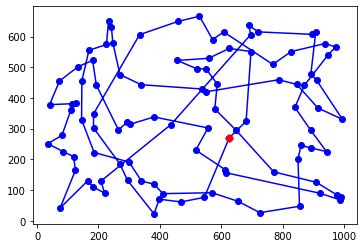

In [ ]:
plot_tour(create_tour(best_individual))

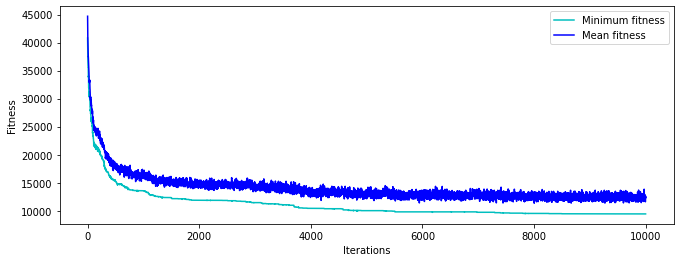

In [ ]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');

# New Section

In [ ]:
def nn_tsp(cities, start=None):
    """Start the tour at the given start city (default: first city); 
    at each step extend the tour by moving from the previous city 
    to its nearest neighbor that has not yet been visited."""
    C = start or first(cities)
    tour = [C]
    unvisited = set(cities - {C})
    while unvisited:
        C = nearest_neighbor(C, unvisited)
        tour.append(C)
        unvisited.remove(C)
    return tour

def first(collection): return next(iter(collection))

def nearest_neighbor(A, cities):
    "Find the city in cities that is nearest to city A."
    return min(cities, key=lambda C: distance(C, A))

In [ ]:
df1=[]
df2=[]
df3=[]
df=[]
for i in range(10,52,2):
  t0 = time.process_time()
  nn_tsp(Cities(i))
  t1 = time.process_time()
  df1.append(i)
  df2.append(t1-t0)
  df3.append(tour_length(nn_tsp(Cities(i))))
df=pd.DataFrame({'Πλήθος Πόλεων':df1,'Χρόνος Εκτέλεσης':df2,"Κόστος Διαδρομής":df3})

In [ ]:
df

,Πλήθος Πόλεων,Χρόνος Εκτέλεσης,Κόστος Διαδρομής
0,10,0.000145,2407.757031
1,12,0.000093,3290.259585
2,14,0.000157,2036.858926
3,16,0.000146,3061.735332
4,18,0.000157,3225.757318
5,20,0.000169,3818.553682
6,22,0.000210,4165.210021
7,24,0.000214,3862.096784
8,26,0.000310,4316.972214
9,28,0.000264,4586.595770


In [ ]:
from google.colab import files
df.to_csv('output.csv', encoding = 'utf-8-sig') 
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def greedy_tsp(cities):
    """Go through links, shortest first. Use a link to join segments if possible."""
    endpoints = {C: [C] for C in cities} # A dict of {endpoint: segment}
    for (A, B) in shortest_links_first(cities):
        if A in endpoints and B in endpoints and endpoints[A] != endpoints[B]:
            new_segment = join_endpoints(endpoints, A, B)
            if len(new_segment) == len(cities):
                return new_segment
            
def improve_greedy_tsp(cities): return improve_tour(greedy_tsp(cities))
            
def shortest_links_first(cities):
    "Return all links between cities, sorted shortest first."
    return sorted(combinations(cities, 2), key=lambda link: distance(*link))
            
# TO DO: join_endpoints

In [ ]:
df1=[]
df2=[]
df3=[]
df=[]
for i in range(10,52,2):
  t0 = time.process_time()
  greedy_tsp(Cities(i))
  t1 = time.process_time()
  df1.append(i)
  df2.append(t1-t0)
  df3.append(tour_length(greedy_tsp(Cities(i))))
df=pd.DataFrame({'Πλήθος Πόλεων':df1,'Χρόνος Εκτέλεσης':df2,"Κόστος Διαδρομής":df3})

In [ ]:
df

,Πλήθος Πόλεων,Χρόνος Εκτέλεσης,Κόστος Διαδρομής
0,10,0.000150,2699.061842
1,12,0.000140,3116.547954
2,14,0.000139,2256.221218
3,16,0.000175,3111.777281
4,18,0.000204,3262.434410
5,20,0.000229,3577.510344
6,22,0.000276,4243.023989
7,24,0.000322,3552.157297
8,26,0.000327,3915.472636
9,28,0.000368,4515.505013


In [ ]:
from google.colab import files
df.to_csv('output.csv', encoding = 'utf-8-sig') 
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>